Module Imports 

In [1]:
# Import necessary libraries
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,AutoConfig,TrainerCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support

/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking if the dataset is loading properly or not 

In [2]:
dataset=pd.read_csv("formatted_combined_dataset.csv")
length=len(dataset)
classes_used=dataset["Class"].unique()
print("The column headers are ",dataset.columns)
print("The length of the dataset is ",length)
print("The distinct abstract classes are ",dataset['Class'].unique())
print(dataset.head())

The column headers are  Index(['Index', 'Abstract', 'Class'], dtype='object')
The length of the dataset is  992
The distinct abstract classes are  ['Sociology' 'Astronomy' 'Psychology']
   Index                                           Abstract       Class
0    726  The process of centrifugally casting an articl...   Sociology
1    109  We present a QCD analysis of the neutral curre...   Astronomy
2    848  While all human associations are entered into ...   Sociology
3    541  Social behavior is ordinarily treated as being...  Psychology
4     65  Phenomena currently attributed to Dark Energy ...   Astronomy


Converting the dataset to a hugging face dataset to train the bert model.Also, mapping the Classes to integers for efficiency.

In [3]:

# Loading the dataset. This dataset has the combined abstract of all fields and they are shuffled as well.
df = pd.read_csv("combined_dataset.csv")  # Use .json or .txt if necessary
# Drop rows where 'Abstract' is invalid (None or not a string)
df = df.dropna(subset=['Abstract'])  # Drop rows with NaN in 'Abstract'
df = df[df['Abstract'].apply(lambda x: isinstance(x, str))]  # Keep only rows where 'Abstract' is a string

#  Map field names to integers
label_map = {'Astronomy': 0, 'Psychology': 1, 'Sociology': 2}
df['label'] = df['Class'].map(label_map)
# Split the dataset into training and test sets
# Convert the pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(df)
list(train_dataset)[1]


{'Index': 741,
 'Abstract': 'In the first edition of Sociology of the Global System, Leslie Sklair argued that social scientists have not yet generally come to regard the whole world as a legitimate object of knowledge. He challenged this practice by establishing the conceptual viability of the global system and by presenting sociological propositions about how it works, and why it works in the ways that it does. In this second edition, Sklair updates his important research with substantial new material relating to intemational corporations, global environmentalism, the socialist Third World, effects of the collapse of communism in the Soviet Union and Eastern Europe, changes in China, and the impact of the Green movement globally. He establishes further evidence that the global system-one based on transnational practices-operates in three spheres: economic, political, and cultural-ideological. In a world largely structured by global capitalism in its various forms, Sklair maintains ea

Class
Sociology     357
Psychology    334
Astronomy     300
Name: count, dtype: int64


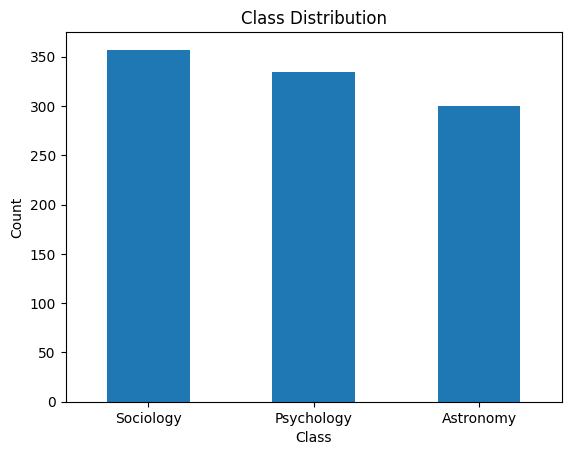

In [4]:
'''
Checking if the dataset is balanced or not. 
Astronomy is easier to predict because of the scientific terms used 
that's why keeping it to lowest to avoid weight bias
'''
class_counts=df["Class"].value_counts()
print(class_counts)
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

In [5]:
#tokenizer so 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Define the tokenization function
def tokenize_function(examples):
    # Tokenize the text and return input_ids, attention_mask
    tokenized = tokenizer(
        examples['Abstract'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'  # Return the outputs as PyTorch tensors directly
    )
    
    return tokenized  # Returns both input_ids and attention_mask

# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
# Ensure 'Abstract' column is dropped, but 'input_ids' and 'attention_mask' remain
train_dataset = train_dataset.remove_columns(['Abstract'])

# Set the correct format for the PyTorch datasets
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Validate by printing a sample from the tokenized dataset
print("Tokenized dataset sample:", train_dataset[0])

Map: 100%|██████████| 991/991 [00:03<00:00, 253.67 examples/s]

Tokenized dataset sample: {'label': tensor(1), 'input_ids': tensor([  101, 10449,  1037,  2047, 17792,  2005,  2060,  2111,  2089, 18708,
         2068,  2000,  3693,  2007,  2017,  1012,  3752,  1010,  2004,  2028,
         1997,  8203, 17792,  1010,  2003,  2641,  2004,  1996,  2200,  3733,
        17792,  2000,  2079,  1012,  2021,  1010,  2116,  2111,  2024,  2025,
         4699,  1999,  2023, 17792,  1012,  2339,  1029, 11771,  2003,  1996,
         3114,  1997,  2339,  1012,  2174,  1010,  2023,  2514,  2941,  2064,
         3066,  2007,  1996,  2338,  1998,  2051,  1997,  2017,  3752,  1012,
         3398,  1010,  2028,  2008,  2057,  2097,  6523,  2000,  3338,  1996,
        29556,  1999,  3752,  2003, 10549,  2013,  5154,  6825,  2000, 10699,
         2671,  2004,  1996,  3752,  3430,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [6]:
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.losses = []  # List to store loss values
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Store loss value every time logging occurs
        if 'loss' in logs:
            self.losses.append(logs['loss'])

    def get_losses(self):
        return self.losses

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_15590/3223583953.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/495 [00:41<31:31,  3.90s/it]

{'loss': 1.0023, 'grad_norm': 2.459990978240967, 'learning_rate': 1.9595959595959596e-05, 'epoch': 0.1}


  4%|▍         | 20/495 [01:21<31:32,  3.98s/it]

{'loss': 0.7345, 'grad_norm': 3.0273447036743164, 'learning_rate': 1.9191919191919194e-05, 'epoch': 0.2}


  6%|▌         | 30/495 [02:01<30:56,  3.99s/it]

{'loss': 0.5382, 'grad_norm': 3.150733470916748, 'learning_rate': 1.8787878787878792e-05, 'epoch': 0.3}


  8%|▊         | 40/495 [02:42<30:43,  4.05s/it]

{'loss': 0.367, 'grad_norm': 2.7822775840759277, 'learning_rate': 1.8383838383838387e-05, 'epoch': 0.4}


 10%|█         | 50/495 [03:22<29:14,  3.94s/it]

{'loss': 0.2439, 'grad_norm': 1.3674812316894531, 'learning_rate': 1.797979797979798e-05, 'epoch': 0.51}


 12%|█▏        | 60/495 [04:02<29:16,  4.04s/it]

{'loss': 0.1634, 'grad_norm': 1.388277292251587, 'learning_rate': 1.7575757575757576e-05, 'epoch': 0.61}


 14%|█▍        | 70/495 [04:41<27:48,  3.93s/it]

{'loss': 0.1212, 'grad_norm': 1.855394959449768, 'learning_rate': 1.7171717171717173e-05, 'epoch': 0.71}


 16%|█▌        | 80/495 [05:24<34:22,  4.97s/it]

{'loss': 0.0902, 'grad_norm': 0.4364605247974396, 'learning_rate': 1.6767676767676768e-05, 'epoch': 0.81}


 18%|█▊        | 90/495 [06:06<27:50,  4.12s/it]

{'loss': 0.0548, 'grad_norm': 6.702332496643066, 'learning_rate': 1.6363636363636366e-05, 'epoch': 0.91}


                                                
 20%|██        | 99/495 [07:09<26:14,  3.98s/it]

{'eval_loss': 0.10614665597677231, 'eval_runtime': 27.6452, 'eval_samples_per_second': 7.198, 'eval_steps_per_second': 0.904, 'epoch': 1.0}


 20%|██        | 100/495 [07:16<1:26:26, 13.13s/it]

{'loss': 0.1218, 'grad_norm': 0.302797794342041, 'learning_rate': 1.595959595959596e-05, 'epoch': 1.01}


 22%|██▏       | 110/495 [07:54<26:24,  4.12s/it]  

{'loss': 0.0881, 'grad_norm': 0.4477028548717499, 'learning_rate': 1.555555555555556e-05, 'epoch': 1.11}


 24%|██▍       | 120/495 [08:34<24:21,  3.90s/it]

{'loss': 0.0469, 'grad_norm': 4.523439407348633, 'learning_rate': 1.5151515151515153e-05, 'epoch': 1.21}


 26%|██▋       | 130/495 [09:13<23:40,  3.89s/it]

{'loss': 0.0303, 'grad_norm': 0.1939077377319336, 'learning_rate': 1.4747474747474747e-05, 'epoch': 1.31}


 28%|██▊       | 140/495 [09:54<24:10,  4.09s/it]

{'loss': 0.0161, 'grad_norm': 0.1784505397081375, 'learning_rate': 1.4343434343434344e-05, 'epoch': 1.41}


 30%|███       | 150/495 [10:34<23:18,  4.05s/it]

{'loss': 0.1193, 'grad_norm': 0.9065533876419067, 'learning_rate': 1.3939393939393942e-05, 'epoch': 1.52}


 32%|███▏      | 160/495 [11:14<22:26,  4.02s/it]

{'loss': 0.0283, 'grad_norm': 0.15671248733997345, 'learning_rate': 1.3535353535353538e-05, 'epoch': 1.62}


 34%|███▍      | 170/495 [11:54<21:18,  3.93s/it]

{'loss': 0.0594, 'grad_norm': 0.21937255561351776, 'learning_rate': 1.3131313131313132e-05, 'epoch': 1.72}


 36%|███▋      | 180/495 [12:34<21:07,  4.02s/it]

{'loss': 0.0254, 'grad_norm': 0.11989015340805054, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.82}


 38%|███▊      | 190/495 [13:14<20:12,  3.98s/it]

{'loss': 0.1198, 'grad_norm': 15.548726081848145, 'learning_rate': 1.2323232323232323e-05, 'epoch': 1.92}


                                                 
 40%|████      | 198/495 [14:12<19:46,  4.00s/it]

{'eval_loss': 0.1155373826622963, 'eval_runtime': 26.6626, 'eval_samples_per_second': 7.464, 'eval_steps_per_second': 0.938, 'epoch': 2.0}


 40%|████      | 200/495 [14:22<48:42,  9.91s/it]  

{'loss': 0.137, 'grad_norm': 0.28766170144081116, 'learning_rate': 1.191919191919192e-05, 'epoch': 2.02}


 42%|████▏     | 210/495 [15:00<19:12,  4.04s/it]

{'loss': 0.0102, 'grad_norm': 0.23940366506576538, 'learning_rate': 1.1515151515151517e-05, 'epoch': 2.12}


 44%|████▍     | 220/495 [15:39<17:26,  3.81s/it]

{'loss': 0.015, 'grad_norm': 0.07881138473749161, 'learning_rate': 1.1111111111111113e-05, 'epoch': 2.22}


 46%|████▋     | 230/495 [16:16<16:36,  3.76s/it]

{'loss': 0.0087, 'grad_norm': 0.10117649286985397, 'learning_rate': 1.0707070707070708e-05, 'epoch': 2.32}


 48%|████▊     | 240/495 [16:55<16:12,  3.81s/it]

{'loss': 0.0877, 'grad_norm': 0.1313416063785553, 'learning_rate': 1.0303030303030304e-05, 'epoch': 2.42}


 51%|█████     | 250/495 [17:31<14:46,  3.62s/it]

{'loss': 0.0078, 'grad_norm': 0.5873132944107056, 'learning_rate': 9.8989898989899e-06, 'epoch': 2.53}


 53%|█████▎    | 260/495 [18:09<15:14,  3.89s/it]

{'loss': 0.0067, 'grad_norm': 0.07561539113521576, 'learning_rate': 9.494949494949497e-06, 'epoch': 2.63}


 55%|█████▍    | 270/495 [18:47<14:15,  3.80s/it]

{'loss': 0.0064, 'grad_norm': 0.08226033300161362, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.73}


 57%|█████▋    | 280/495 [19:25<13:35,  3.79s/it]

{'loss': 0.0058, 'grad_norm': 0.07366999983787537, 'learning_rate': 8.686868686868687e-06, 'epoch': 2.83}


 59%|█████▊    | 290/495 [20:04<13:25,  3.93s/it]

{'loss': 0.0279, 'grad_norm': 24.2457275390625, 'learning_rate': 8.282828282828283e-06, 'epoch': 2.93}


                                                 
 60%|██████    | 297/495 [21:06<12:28,  3.78s/it]

{'eval_loss': 0.0666416808962822, 'eval_runtime': 35.3205, 'eval_samples_per_second': 5.634, 'eval_steps_per_second': 0.708, 'epoch': 3.0}


 61%|██████    | 300/495 [21:22<32:43, 10.07s/it]

{'loss': 0.0055, 'grad_norm': 0.05987062305212021, 'learning_rate': 7.87878787878788e-06, 'epoch': 3.03}


 63%|██████▎   | 310/495 [22:09<16:38,  5.39s/it]

{'loss': 0.0077, 'grad_norm': 0.07639869302511215, 'learning_rate': 7.474747474747476e-06, 'epoch': 3.13}


 65%|██████▍   | 320/495 [22:49<12:00,  4.12s/it]

{'loss': 0.0049, 'grad_norm': 0.06734184175729752, 'learning_rate': 7.070707070707071e-06, 'epoch': 3.23}


 67%|██████▋   | 330/495 [23:32<11:33,  4.21s/it]

{'loss': 0.0212, 'grad_norm': 0.06114283949136734, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}


 69%|██████▊   | 340/495 [24:12<10:17,  3.99s/it]

{'loss': 0.0047, 'grad_norm': 0.06204655021429062, 'learning_rate': 6.262626262626264e-06, 'epoch': 3.43}


 71%|███████   | 350/495 [24:54<10:20,  4.28s/it]

{'loss': 0.0741, 'grad_norm': 0.07711835205554962, 'learning_rate': 5.858585858585859e-06, 'epoch': 3.54}


 73%|███████▎  | 360/495 [25:35<08:46,  3.90s/it]

{'loss': 0.0047, 'grad_norm': 0.050064992159605026, 'learning_rate': 5.4545454545454545e-06, 'epoch': 3.64}


 75%|███████▍  | 370/495 [26:17<08:27,  4.06s/it]

{'loss': 0.0043, 'grad_norm': 0.05484538897871971, 'learning_rate': 5.0505050505050515e-06, 'epoch': 3.74}


 77%|███████▋  | 380/495 [26:59<08:02,  4.20s/it]

{'loss': 0.0036, 'grad_norm': 0.05463792383670807, 'learning_rate': 4.646464646464647e-06, 'epoch': 3.84}


 79%|███████▉  | 390/495 [27:39<06:53,  3.94s/it]

{'loss': 0.0058, 'grad_norm': 0.059904634952545166, 'learning_rate': 4.242424242424243e-06, 'epoch': 3.94}


                                                 
 80%|████████  | 396/495 [28:39<06:49,  4.13s/it]

{'eval_loss': 0.06481760740280151, 'eval_runtime': 35.3053, 'eval_samples_per_second': 5.637, 'eval_steps_per_second': 0.708, 'epoch': 4.0}


 81%|████████  | 400/495 [29:02<13:43,  8.67s/it]

{'loss': 0.0038, 'grad_norm': 0.04073058441281319, 'learning_rate': 3.8383838383838385e-06, 'epoch': 4.04}


 83%|████████▎ | 410/495 [29:45<06:02,  4.26s/it]

{'loss': 0.0036, 'grad_norm': 0.05036167800426483, 'learning_rate': 3.4343434343434347e-06, 'epoch': 4.14}


 85%|████████▍ | 420/495 [30:26<05:08,  4.12s/it]

{'loss': 0.0036, 'grad_norm': 0.06414861977100372, 'learning_rate': 3.0303030303030305e-06, 'epoch': 4.24}


 87%|████████▋ | 430/495 [31:07<04:28,  4.12s/it]

{'loss': 0.0039, 'grad_norm': 0.054514605551958084, 'learning_rate': 2.6262626262626267e-06, 'epoch': 4.34}


 89%|████████▉ | 440/495 [31:48<03:43,  4.07s/it]

{'loss': 0.0037, 'grad_norm': 0.04294602572917938, 'learning_rate': 2.222222222222222e-06, 'epoch': 4.44}


 91%|█████████ | 450/495 [32:29<03:04,  4.10s/it]

{'loss': 0.0043, 'grad_norm': 0.05282707139849663, 'learning_rate': 1.8181818181818183e-06, 'epoch': 4.55}


 93%|█████████▎| 460/495 [33:10<02:22,  4.07s/it]

{'loss': 0.0035, 'grad_norm': 0.04513678327202797, 'learning_rate': 1.4141414141414143e-06, 'epoch': 4.65}


 95%|█████████▍| 470/495 [33:51<01:43,  4.12s/it]

{'loss': 0.0106, 'grad_norm': 0.055189114063978195, 'learning_rate': 1.01010101010101e-06, 'epoch': 4.75}


 97%|█████████▋| 480/495 [34:33<01:02,  4.16s/it]

{'loss': 0.0042, 'grad_norm': 0.1298285871744156, 'learning_rate': 6.060606060606061e-07, 'epoch': 4.85}


 99%|█████████▉| 490/495 [35:13<00:19,  3.97s/it]

{'loss': 0.0036, 'grad_norm': 0.05153670907020569, 'learning_rate': 2.0202020202020205e-07, 'epoch': 4.95}


                                                 
100%|██████████| 495/495 [36:07<00:00,  3.99s/it]

{'eval_loss': 0.06490129977464676, 'eval_runtime': 30.791, 'eval_samples_per_second': 6.463, 'eval_steps_per_second': 0.812, 'epoch': 5.0}


100%|██████████| 495/495 [36:09<00:00,  4.38s/it]


{'train_runtime': 2169.6149, 'train_samples_per_second': 1.825, 'train_steps_per_second': 0.228, 'train_loss': 0.09025386711864761, 'epoch': 5.0}


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Fold 1 Evaluation Results: {'eval_loss': 0.06481760740280151, 'eval_runtime': 25.7254, 'eval_samples_per_second': 7.736, 'eval_steps_per_second': 0.972, 'epoch': 5.0}


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


Test Accuracy: 0.9799
Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        62
  Psychology       0.98      0.95      0.97        60
   Sociology       0.96      0.99      0.97        77

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199

Fold 1 Confusion Matrix:
[[62  0  0]
 [ 0 57  3]
 [ 0  1 76]]
Fold 1 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        62
  Psychology       0.98      0.95      0.97        60
   Sociology       0.96      0.99      0.97        77

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199



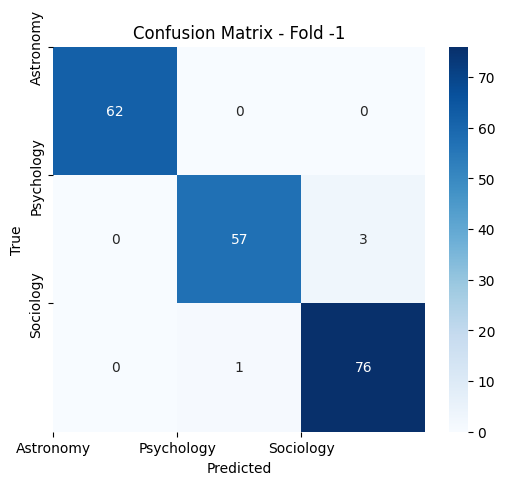

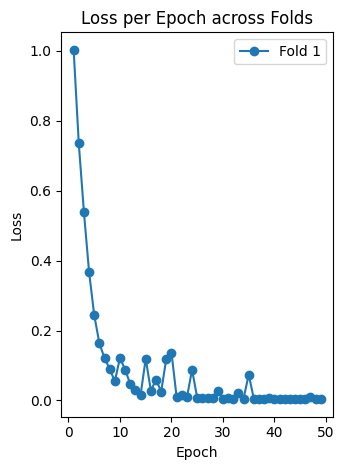

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_15590/3223583953.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/500 [00:43<36:04,  4.42s/it]

{'loss': 1.0201, 'grad_norm': 2.894521474838257, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.1}


  4%|▍         | 20/500 [01:24<33:00,  4.13s/it]

{'loss': 0.821, 'grad_norm': 4.039096355438232, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.2}


  6%|▌         | 30/500 [02:02<29:09,  3.72s/it]

{'loss': 0.5792, 'grad_norm': 2.9715020656585693, 'learning_rate': 1.88e-05, 'epoch': 0.3}


  8%|▊         | 40/500 [02:39<28:03,  3.66s/it]

{'loss': 0.3556, 'grad_norm': 2.637237787246704, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.4}


 10%|█         | 50/500 [03:16<27:52,  3.72s/it]

{'loss': 0.2692, 'grad_norm': 4.706262588500977, 'learning_rate': 1.8e-05, 'epoch': 0.5}


 12%|█▏        | 60/500 [03:53<26:30,  3.61s/it]

{'loss': 0.1936, 'grad_norm': 5.327683925628662, 'learning_rate': 1.76e-05, 'epoch': 0.6}


 14%|█▍        | 70/500 [04:31<26:53,  3.75s/it]

{'loss': 0.1422, 'grad_norm': 1.0458269119262695, 'learning_rate': 1.72e-05, 'epoch': 0.7}


 16%|█▌        | 80/500 [05:09<26:11,  3.74s/it]

{'loss': 0.0745, 'grad_norm': 2.238996982574463, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.8}


 18%|█▊        | 90/500 [05:46<25:10,  3.68s/it]

{'loss': 0.0934, 'grad_norm': 0.33110108971595764, 'learning_rate': 1.64e-05, 'epoch': 0.9}


 20%|██        | 100/500 [06:21<21:42,  3.26s/it]

{'loss': 0.0751, 'grad_norm': 0.5251445174217224, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                 
 20%|██        | 100/500 [06:52<21:42,  3.26s/it]

{'eval_loss': 0.142338827252388, 'eval_runtime': 30.6607, 'eval_samples_per_second': 6.458, 'eval_steps_per_second': 0.815, 'epoch': 1.0}


 22%|██▏       | 110/500 [07:32<24:38,  3.79s/it]  

{'loss': 0.0353, 'grad_norm': 0.33092159032821655, 'learning_rate': 1.5600000000000003e-05, 'epoch': 1.1}


 24%|██▍       | 120/500 [08:10<24:00,  3.79s/it]

{'loss': 0.1324, 'grad_norm': 15.225410461425781, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}


 26%|██▌       | 130/500 [08:47<22:58,  3.73s/it]

{'loss': 0.0204, 'grad_norm': 0.18756933510303497, 'learning_rate': 1.48e-05, 'epoch': 1.3}


 28%|██▊       | 140/500 [09:24<21:46,  3.63s/it]

{'loss': 0.0625, 'grad_norm': 0.15532547235488892, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.4}


 30%|███       | 150/500 [10:02<21:47,  3.74s/it]

{'loss': 0.0678, 'grad_norm': 0.14996851980686188, 'learning_rate': 1.4e-05, 'epoch': 1.5}


 32%|███▏      | 160/500 [10:39<21:13,  3.75s/it]

{'loss': 0.1023, 'grad_norm': 0.6690232157707214, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.6}


 34%|███▍      | 170/500 [11:26<30:15,  5.50s/it]

{'loss': 0.0115, 'grad_norm': 0.190094456076622, 'learning_rate': 1.3200000000000002e-05, 'epoch': 1.7}


 36%|███▌      | 180/500 [14:40<1:44:38, 19.62s/it]

{'loss': 0.0164, 'grad_norm': 6.1026082038879395, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.8}


 38%|███▊      | 190/500 [15:19<20:51,  4.04s/it]  

{'loss': 0.0117, 'grad_norm': 0.09506192058324814, 'learning_rate': 1.2400000000000002e-05, 'epoch': 1.9}


 40%|████      | 200/500 [15:54<15:27,  3.09s/it]

{'loss': 0.0728, 'grad_norm': 0.21508242189884186, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 200/500 [16:31<15:27,  3.09s/it]

{'eval_loss': 0.12883034348487854, 'eval_runtime': 36.4857, 'eval_samples_per_second': 5.427, 'eval_steps_per_second': 0.685, 'epoch': 2.0}


 42%|████▏     | 210/500 [17:24<22:18,  4.62s/it]  

{'loss': 0.0099, 'grad_norm': 1.3256494998931885, 'learning_rate': 1.16e-05, 'epoch': 2.1}


 44%|████▍     | 220/500 [18:02<16:59,  3.64s/it]

{'loss': 0.0081, 'grad_norm': 0.10468608140945435, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.2}


 46%|████▌     | 230/500 [18:40<16:49,  3.74s/it]

{'loss': 0.018, 'grad_norm': 0.0794638991355896, 'learning_rate': 1.0800000000000002e-05, 'epoch': 2.3}


 48%|████▊     | 240/500 [19:18<16:20,  3.77s/it]

{'loss': 0.0265, 'grad_norm': 0.08451481908559799, 'learning_rate': 1.04e-05, 'epoch': 2.4}


 50%|█████     | 250/500 [19:57<15:45,  3.78s/it]

{'loss': 0.0085, 'grad_norm': 0.09825253486633301, 'learning_rate': 1e-05, 'epoch': 2.5}


 52%|█████▏    | 260/500 [20:34<14:31,  3.63s/it]

{'loss': 0.0072, 'grad_norm': 0.07230209559202194, 'learning_rate': 9.600000000000001e-06, 'epoch': 2.6}


 54%|█████▍    | 270/500 [21:15<15:42,  4.10s/it]

{'loss': 0.0059, 'grad_norm': 0.08265957981348038, 'learning_rate': 9.200000000000002e-06, 'epoch': 2.7}


 56%|█████▌    | 280/500 [21:52<13:01,  3.55s/it]

{'loss': 0.0335, 'grad_norm': 0.09430136531591415, 'learning_rate': 8.8e-06, 'epoch': 2.8}


 58%|█████▊    | 290/500 [22:34<14:31,  4.15s/it]

{'loss': 0.0053, 'grad_norm': 0.08261936902999878, 'learning_rate': 8.400000000000001e-06, 'epoch': 2.9}


 60%|██████    | 300/500 [23:12<09:58,  2.99s/it]

{'loss': 0.0569, 'grad_norm': 0.09480183571577072, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 300/500 [23:41<09:58,  2.99s/it]

{'eval_loss': 0.16624239087104797, 'eval_runtime': 29.4321, 'eval_samples_per_second': 6.727, 'eval_steps_per_second': 0.849, 'epoch': 3.0}


 62%|██████▏   | 310/500 [24:22<13:18,  4.20s/it]

{'loss': 0.005, 'grad_norm': 0.05613354593515396, 'learning_rate': 7.600000000000001e-06, 'epoch': 3.1}


 64%|██████▍   | 320/500 [25:04<12:01,  4.01s/it]

{'loss': 0.0052, 'grad_norm': 0.04978866130113602, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}


 66%|██████▌   | 330/500 [25:44<10:24,  3.67s/it]

{'loss': 0.0048, 'grad_norm': 0.07530571520328522, 'learning_rate': 6.800000000000001e-06, 'epoch': 3.3}


 68%|██████▊   | 340/500 [26:19<08:20,  3.13s/it]

{'loss': 0.0045, 'grad_norm': 0.06234408915042877, 'learning_rate': 6.4000000000000006e-06, 'epoch': 3.4}


 70%|███████   | 350/500 [26:52<08:09,  3.26s/it]

{'loss': 0.0044, 'grad_norm': 0.048951394855976105, 'learning_rate': 6e-06, 'epoch': 3.5}


 72%|███████▏  | 360/500 [27:31<09:08,  3.92s/it]

{'loss': 0.0042, 'grad_norm': 0.10162875801324844, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}


 74%|███████▍  | 370/500 [28:13<08:26,  3.90s/it]

{'loss': 0.0042, 'grad_norm': 0.05044354125857353, 'learning_rate': 5.2e-06, 'epoch': 3.7}


 76%|███████▌  | 380/500 [44:02<39:01, 19.51s/it]   

{'loss': 0.0043, 'grad_norm': 0.0617666058242321, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.8}


 78%|███████▊  | 390/500 [44:42<07:52,  4.30s/it]

{'loss': 0.0049, 'grad_norm': 0.5432660579681396, 'learning_rate': 4.4e-06, 'epoch': 3.9}


 80%|████████  | 400/500 [45:20<05:20,  3.20s/it]

{'loss': 0.0039, 'grad_norm': 0.06954066455364227, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 400/500 [45:54<05:20,  3.20s/it]

{'eval_loss': 0.15175551176071167, 'eval_runtime': 33.0277, 'eval_samples_per_second': 5.995, 'eval_steps_per_second': 0.757, 'epoch': 4.0}


 82%|████████▏ | 410/500 [46:38<06:44,  4.50s/it]

{'loss': 0.004, 'grad_norm': 0.07215079665184021, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.1}


 84%|████████▍ | 420/500 [47:19<05:04,  3.81s/it]

{'loss': 0.0034, 'grad_norm': 0.03885064274072647, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.2}


 86%|████████▌ | 430/500 [47:56<04:05,  3.50s/it]

{'loss': 0.004, 'grad_norm': 0.09753575176000595, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.3}


 88%|████████▊ | 440/500 [48:31<03:24,  3.41s/it]

{'loss': 0.0035, 'grad_norm': 0.04224449396133423, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.4}


 90%|█████████ | 450/500 [49:09<03:07,  3.76s/it]

{'loss': 0.0035, 'grad_norm': 0.04464152082800865, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.5}


 92%|█████████▏| 460/500 [49:48<02:22,  3.55s/it]

{'loss': 0.0038, 'grad_norm': 0.06449105590581894, 'learning_rate': 1.6000000000000001e-06, 'epoch': 4.6}


 94%|█████████▍| 470/500 [50:27<01:57,  3.93s/it]

{'loss': 0.004, 'grad_norm': 0.17708399891853333, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.7}


 96%|█████████▌| 480/500 [51:03<01:14,  3.75s/it]

{'loss': 0.0033, 'grad_norm': 0.048605069518089294, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


 98%|█████████▊| 490/500 [51:43<00:41,  4.19s/it]

{'loss': 0.0035, 'grad_norm': 0.0423574335873127, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.9}


100%|██████████| 500/500 [52:20<00:00,  2.98s/it]

{'loss': 0.0033, 'grad_norm': 0.07837390899658203, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 500/500 [53:01<00:00,  2.98s/it]

{'eval_loss': 0.15763872861862183, 'eval_runtime': 37.9043, 'eval_samples_per_second': 5.224, 'eval_steps_per_second': 0.66, 'epoch': 5.0}


100%|██████████| 500/500 [53:06<00:00,  6.37s/it]


{'train_runtime': 3186.1321, 'train_samples_per_second': 1.244, 'train_steps_per_second': 0.157, 'train_loss': 0.08837088606506587, 'epoch': 5.0}


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Fold 2 Evaluation Results: {'eval_loss': 0.12883034348487854, 'eval_runtime': 36.0095, 'eval_samples_per_second': 5.499, 'eval_steps_per_second': 0.694, 'epoch': 5.0}


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Test Accuracy: 0.9596
Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        58
  Psychology       0.94      0.94      0.94        66
   Sociology       0.95      0.95      0.95        74

    accuracy                           0.96       198
   macro avg       0.96      0.96      0.96       198
weighted avg       0.96      0.96      0.96       198

Fold 2 Confusion Matrix:
[[58  0  0]
 [ 0 62  4]
 [ 0  4 70]]
Fold 2 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        58
  Psychology       0.94      0.94      0.94        66
   Sociology       0.95      0.95      0.95        74

    accuracy                           0.96       198
   macro avg       0.96      0.96      0.96       198
weighted avg       0.96      0.96      0.96       198



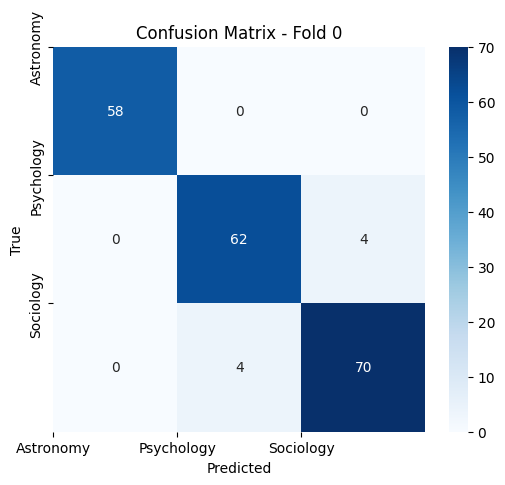

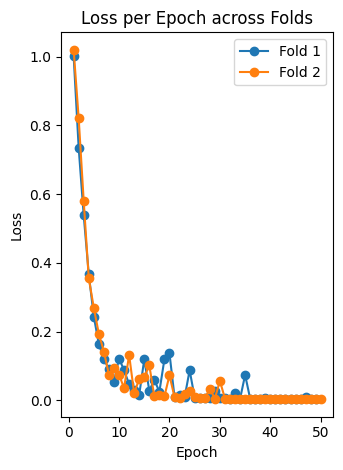

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_15590/3223583953.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/500 [00:59<34:17,  4.20s/it] 

{'loss': 1.0346, 'grad_norm': 3.1746644973754883, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.1}


  4%|▍         | 20/500 [01:41<32:33,  4.07s/it]

{'loss': 0.8274, 'grad_norm': 3.1186635494232178, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.2}


  6%|▌         | 30/500 [02:28<46:18,  5.91s/it]

{'loss': 0.623, 'grad_norm': 3.7638700008392334, 'learning_rate': 1.88e-05, 'epoch': 0.3}


  8%|▊         | 40/500 [03:08<30:28,  3.98s/it]

{'loss': 0.4367, 'grad_norm': 2.381836414337158, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.4}


 10%|█         | 50/500 [03:47<28:12,  3.76s/it]

{'loss': 0.2863, 'grad_norm': 1.5178240537643433, 'learning_rate': 1.8e-05, 'epoch': 0.5}


 12%|█▏        | 60/500 [04:26<28:47,  3.93s/it]

{'loss': 0.1492, 'grad_norm': 0.9105561375617981, 'learning_rate': 1.76e-05, 'epoch': 0.6}


 14%|█▍        | 70/500 [05:07<32:23,  4.52s/it]

{'loss': 0.1721, 'grad_norm': 1.5494239330291748, 'learning_rate': 1.72e-05, 'epoch': 0.7}


 16%|█▌        | 80/500 [06:05<32:26,  4.64s/it]

{'loss': 0.1533, 'grad_norm': 6.5311431884765625, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.8}


 18%|█▊        | 90/500 [07:18<45:33,  6.67s/it]  

{'loss': 0.0832, 'grad_norm': 0.4009191393852234, 'learning_rate': 1.64e-05, 'epoch': 0.9}


 20%|██        | 100/500 [07:55<20:12,  3.03s/it]

{'loss': 0.0522, 'grad_norm': 0.4829657971858978, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                 
 20%|██        | 100/500 [08:24<20:12,  3.03s/it]

{'eval_loss': 0.06554620712995529, 'eval_runtime': 28.4153, 'eval_samples_per_second': 6.968, 'eval_steps_per_second': 0.88, 'epoch': 1.0}


 22%|██▏       | 110/500 [09:43<1:12:49, 11.20s/it]

{'loss': 0.0705, 'grad_norm': 0.2942570149898529, 'learning_rate': 1.5600000000000003e-05, 'epoch': 1.1}


 24%|██▍       | 120/500 [10:40<33:28,  5.28s/it]  

{'loss': 0.0292, 'grad_norm': 0.29920437932014465, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}


 26%|██▌       | 130/500 [11:31<30:02,  4.87s/it]

{'loss': 0.0763, 'grad_norm': 0.19723764061927795, 'learning_rate': 1.48e-05, 'epoch': 1.3}


 28%|██▊       | 140/500 [12:15<24:19,  4.05s/it]

{'loss': 0.0422, 'grad_norm': 13.27846908569336, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.4}


 30%|███       | 150/500 [12:56<24:07,  4.14s/it]

{'loss': 0.0379, 'grad_norm': 1.0964328050613403, 'learning_rate': 1.4e-05, 'epoch': 1.5}


 32%|███▏      | 160/500 [13:36<22:47,  4.02s/it]

{'loss': 0.0686, 'grad_norm': 0.17699436843395233, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.6}


 34%|███▍      | 170/500 [14:20<23:28,  4.27s/it]

{'loss': 0.1103, 'grad_norm': 0.12729579210281372, 'learning_rate': 1.3200000000000002e-05, 'epoch': 1.7}


 36%|███▌      | 180/500 [15:05<22:44,  4.26s/it]

{'loss': 0.0598, 'grad_norm': 0.33769240975379944, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.8}


 38%|███▊      | 190/500 [15:46<20:25,  3.95s/it]

{'loss': 0.0487, 'grad_norm': 0.21568119525909424, 'learning_rate': 1.2400000000000002e-05, 'epoch': 1.9}


 40%|████      | 200/500 [16:23<15:43,  3.14s/it]

{'loss': 0.0242, 'grad_norm': 0.38096728920936584, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 200/500 [16:52<15:43,  3.14s/it]

{'eval_loss': 0.05952545255422592, 'eval_runtime': 28.8612, 'eval_samples_per_second': 6.86, 'eval_steps_per_second': 0.866, 'epoch': 2.0}


 42%|████▏     | 210/500 [18:00<41:03,  8.50s/it]  

{'loss': 0.0156, 'grad_norm': 1.275158166885376, 'learning_rate': 1.16e-05, 'epoch': 2.1}


 44%|████▍     | 220/500 [18:51<27:05,  5.80s/it]

{'loss': 0.0132, 'grad_norm': 0.21614916622638702, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.2}


 46%|████▌     | 230/500 [19:36<18:24,  4.09s/it]

{'loss': 0.0074, 'grad_norm': 0.09324907511472702, 'learning_rate': 1.0800000000000002e-05, 'epoch': 2.3}


 48%|████▊     | 240/500 [20:17<19:04,  4.40s/it]

{'loss': 0.0485, 'grad_norm': 0.08730046451091766, 'learning_rate': 1.04e-05, 'epoch': 2.4}


 50%|█████     | 250/500 [21:08<20:47,  4.99s/it]

{'loss': 0.0446, 'grad_norm': 0.09223445504903793, 'learning_rate': 1e-05, 'epoch': 2.5}


 52%|█████▏    | 260/500 [21:42<13:22,  3.34s/it]

{'loss': 0.0103, 'grad_norm': 0.10724417865276337, 'learning_rate': 9.600000000000001e-06, 'epoch': 2.6}


 54%|█████▍    | 270/500 [27:23<2:22:50, 37.26s/it]

{'loss': 0.0091, 'grad_norm': 0.07491640001535416, 'learning_rate': 9.200000000000002e-06, 'epoch': 2.7}


 56%|█████▌    | 280/500 [28:09<19:31,  5.32s/it]  

{'loss': 0.0094, 'grad_norm': 0.09281088411808014, 'learning_rate': 8.8e-06, 'epoch': 2.8}


 58%|█████▊    | 290/500 [28:52<14:28,  4.13s/it]

{'loss': 0.0417, 'grad_norm': 0.07198687642812729, 'learning_rate': 8.400000000000001e-06, 'epoch': 2.9}


 60%|██████    | 300/500 [29:30<10:41,  3.21s/it]

{'loss': 0.0054, 'grad_norm': 0.13478495180606842, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 300/500 [29:58<10:41,  3.21s/it]

{'eval_loss': 0.06046709418296814, 'eval_runtime': 28.4971, 'eval_samples_per_second': 6.948, 'eval_steps_per_second': 0.877, 'epoch': 3.0}


 62%|██████▏   | 310/500 [30:52<14:34,  4.60s/it]

{'loss': 0.0057, 'grad_norm': 0.06356033682823181, 'learning_rate': 7.600000000000001e-06, 'epoch': 3.1}


 64%|██████▍   | 320/500 [31:39<13:16,  4.43s/it]

{'loss': 0.0053, 'grad_norm': 0.0791257694363594, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}


 66%|██████▌   | 330/500 [32:23<12:02,  4.25s/it]

{'loss': 0.0059, 'grad_norm': 0.06464868038892746, 'learning_rate': 6.800000000000001e-06, 'epoch': 3.3}


 68%|██████▊   | 340/500 [33:04<10:33,  3.96s/it]

{'loss': 0.0048, 'grad_norm': 0.05956638604402542, 'learning_rate': 6.4000000000000006e-06, 'epoch': 3.4}


 70%|███████   | 350/500 [33:46<09:58,  3.99s/it]

{'loss': 0.0045, 'grad_norm': 0.06146879121661186, 'learning_rate': 6e-06, 'epoch': 3.5}


 72%|███████▏  | 360/500 [34:28<09:11,  3.94s/it]

{'loss': 0.004, 'grad_norm': 0.04788745939731598, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}


 74%|███████▍  | 370/500 [35:08<08:37,  3.98s/it]

{'loss': 0.0041, 'grad_norm': 0.06954775005578995, 'learning_rate': 5.2e-06, 'epoch': 3.7}


 76%|███████▌  | 380/500 [35:47<07:36,  3.81s/it]

{'loss': 0.0199, 'grad_norm': 0.05779626592993736, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.8}


 78%|███████▊  | 390/500 [36:31<07:20,  4.00s/it]

{'loss': 0.0051, 'grad_norm': 0.05792146921157837, 'learning_rate': 4.4e-06, 'epoch': 3.9}


 80%|████████  | 400/500 [37:09<05:17,  3.18s/it]

{'loss': 0.0036, 'grad_norm': 0.05026647821068764, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 400/500 [38:05<05:17,  3.18s/it]

{'eval_loss': 0.0668240487575531, 'eval_runtime': 55.7516, 'eval_samples_per_second': 3.551, 'eval_steps_per_second': 0.448, 'epoch': 4.0}


 82%|████████▏ | 410/500 [39:04<08:46,  5.85s/it]

{'loss': 0.0038, 'grad_norm': 0.03977786749601364, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.1}


 84%|████████▍ | 420/500 [39:53<05:58,  4.48s/it]

{'loss': 0.0037, 'grad_norm': 0.04755643755197525, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.2}


 86%|████████▌ | 430/500 [40:59<06:00,  5.15s/it]

{'loss': 0.0054, 'grad_norm': 0.09105614572763443, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.3}


 88%|████████▊ | 440/500 [41:41<04:00,  4.01s/it]

{'loss': 0.0038, 'grad_norm': 0.059656113386154175, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.4}


 90%|█████████ | 450/500 [42:21<03:22,  4.04s/it]

{'loss': 0.0034, 'grad_norm': 0.039890438318252563, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.5}


 92%|█████████▏| 460/500 [43:03<02:57,  4.43s/it]

{'loss': 0.0036, 'grad_norm': 0.05475085973739624, 'learning_rate': 1.6000000000000001e-06, 'epoch': 4.6}


 94%|█████████▍| 470/500 [43:48<02:19,  4.67s/it]

{'loss': 0.0042, 'grad_norm': 0.042327843606472015, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.7}


 96%|█████████▌| 480/500 [44:34<01:28,  4.40s/it]

{'loss': 0.0034, 'grad_norm': 0.036672212183475494, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


 98%|█████████▊| 490/500 [45:15<00:42,  4.22s/it]

{'loss': 0.0039, 'grad_norm': 0.0749286338686943, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.9}


100%|██████████| 500/500 [45:55<00:00,  3.25s/it]

{'loss': 0.0038, 'grad_norm': 0.10610924661159515, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 500/500 [46:36<00:00,  3.25s/it]

{'eval_loss': 0.06859923899173737, 'eval_runtime': 35.9956, 'eval_samples_per_second': 5.501, 'eval_steps_per_second': 0.695, 'epoch': 5.0}


100%|██████████| 500/500 [46:46<00:00,  5.61s/it]


{'train_runtime': 2805.9766, 'train_samples_per_second': 1.413, 'train_steps_per_second': 0.178, 'train_loss': 0.09386360721290112, 'epoch': 5.0}


100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


Fold 3 Evaluation Results: {'eval_loss': 0.05952545255422592, 'eval_runtime': 45.6765, 'eval_samples_per_second': 4.335, 'eval_steps_per_second': 0.547, 'epoch': 5.0}


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Test Accuracy: 0.9899
Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        64
  Psychology       1.00      0.97      0.98        65
   Sociology       0.97      1.00      0.99        69

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198

Fold 3 Confusion Matrix:
[[64  0  0]
 [ 0 63  2]
 [ 0  0 69]]
Fold 3 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00        64
  Psychology       1.00      0.97      0.98        65
   Sociology       0.97      1.00      0.99        69

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198



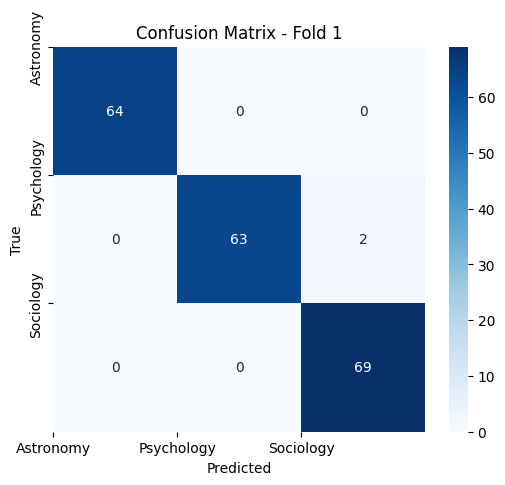

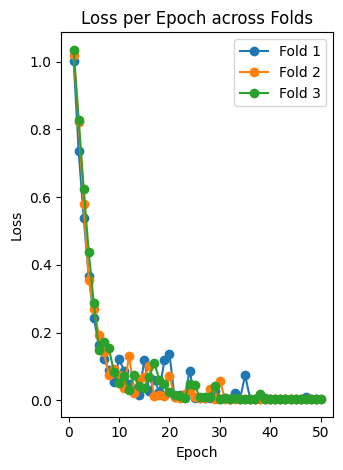

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_15590/3223583953.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/500 [00:59<40:09,  4.92s/it] 

{'loss': 1.0395, 'grad_norm': 2.7179317474365234, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.1}


  4%|▍         | 20/500 [01:47<37:28,  4.68s/it]

{'loss': 0.8697, 'grad_norm': 2.5972044467926025, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.2}


  6%|▌         | 30/500 [02:41<44:54,  5.73s/it]

{'loss': 0.6098, 'grad_norm': 2.6486198902130127, 'learning_rate': 1.88e-05, 'epoch': 0.3}


  8%|▊         | 40/500 [03:30<38:33,  5.03s/it]

{'loss': 0.4298, 'grad_norm': 2.376610279083252, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.4}


 10%|█         | 50/500 [04:19<32:35,  4.35s/it]

{'loss': 0.2708, 'grad_norm': 1.0817902088165283, 'learning_rate': 1.8e-05, 'epoch': 0.5}


 12%|█▏        | 60/500 [05:17<39:27,  5.38s/it]

{'loss': 0.2055, 'grad_norm': 0.8305482268333435, 'learning_rate': 1.76e-05, 'epoch': 0.6}


 14%|█▍        | 70/500 [06:16<32:47,  4.57s/it]  

{'loss': 0.1517, 'grad_norm': 0.6883907914161682, 'learning_rate': 1.72e-05, 'epoch': 0.7}


 16%|█▌        | 80/500 [07:01<29:52,  4.27s/it]

{'loss': 0.1211, 'grad_norm': 0.8954355120658875, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.8}


 18%|█▊        | 90/500 [07:46<30:04,  4.40s/it]

{'loss': 0.0978, 'grad_norm': 0.34509989619255066, 'learning_rate': 1.64e-05, 'epoch': 0.9}


 20%|██        | 100/500 [08:27<21:11,  3.18s/it]

{'loss': 0.1297, 'grad_norm': 0.49551910161972046, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                 
 20%|██        | 100/500 [09:14<21:11,  3.18s/it]

{'eval_loss': 0.11853508651256561, 'eval_runtime': 46.8078, 'eval_samples_per_second': 4.23, 'eval_steps_per_second': 0.534, 'epoch': 1.0}


 22%|██▏       | 110/500 [10:25<49:55,  7.68s/it]  

{'loss': 0.0714, 'grad_norm': 12.03832721710205, 'learning_rate': 1.5600000000000003e-05, 'epoch': 1.1}


 24%|██▍       | 120/500 [11:16<30:36,  4.83s/it]

{'loss': 0.094, 'grad_norm': 0.2612713873386383, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}


 26%|██▌       | 130/500 [11:58<24:26,  3.96s/it]

{'loss': 0.0565, 'grad_norm': 9.357339859008789, 'learning_rate': 1.48e-05, 'epoch': 1.3}


 28%|██▊       | 140/500 [12:35<22:04,  3.68s/it]

{'loss': 0.165, 'grad_norm': 7.8617119789123535, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.4}


 30%|███       | 150/500 [13:15<22:11,  3.80s/it]

{'loss': 0.0249, 'grad_norm': 1.1362468004226685, 'learning_rate': 1.4e-05, 'epoch': 1.5}


 32%|███▏      | 160/500 [13:54<22:12,  3.92s/it]

{'loss': 0.0288, 'grad_norm': 5.885769367218018, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.6}


 34%|███▍      | 170/500 [14:42<23:16,  4.23s/it]

{'loss': 0.0995, 'grad_norm': 0.5974237322807312, 'learning_rate': 1.3200000000000002e-05, 'epoch': 1.7}


 36%|███▌      | 180/500 [15:20<18:51,  3.54s/it]

{'loss': 0.0313, 'grad_norm': 0.1803198903799057, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.8}


 38%|███▊      | 190/500 [15:59<20:00,  3.87s/it]

{'loss': 0.0192, 'grad_norm': 4.543661117553711, 'learning_rate': 1.2400000000000002e-05, 'epoch': 1.9}


 40%|████      | 200/500 [16:33<14:04,  2.81s/it]

{'loss': 0.0165, 'grad_norm': 0.35645830631256104, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 200/500 [17:00<14:04,  2.81s/it]

{'eval_loss': 0.10565348714590073, 'eval_runtime': 27.1989, 'eval_samples_per_second': 7.28, 'eval_steps_per_second': 0.919, 'epoch': 2.0}


 42%|████▏     | 210/500 [17:54<22:56,  4.75s/it]  

{'loss': 0.0122, 'grad_norm': 0.1475318968296051, 'learning_rate': 1.16e-05, 'epoch': 2.1}


 44%|████▍     | 220/500 [18:35<17:48,  3.82s/it]

{'loss': 0.0105, 'grad_norm': 0.12027397006750107, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.2}


 46%|████▌     | 230/500 [19:34<36:03,  8.01s/it]

{'loss': 0.008, 'grad_norm': 0.10495854169130325, 'learning_rate': 1.0800000000000002e-05, 'epoch': 2.3}


 48%|████▊     | 240/500 [20:23<18:56,  4.37s/it]

{'loss': 0.0106, 'grad_norm': 0.10172770917415619, 'learning_rate': 1.04e-05, 'epoch': 2.4}


 50%|█████     | 250/500 [20:59<15:06,  3.63s/it]

{'loss': 0.0079, 'grad_norm': 0.08723148703575134, 'learning_rate': 1e-05, 'epoch': 2.5}


 52%|█████▏    | 260/500 [21:38<15:01,  3.75s/it]

{'loss': 0.0617, 'grad_norm': 0.07720623910427094, 'learning_rate': 9.600000000000001e-06, 'epoch': 2.6}


 54%|█████▍    | 270/500 [22:15<14:07,  3.68s/it]

{'loss': 0.0487, 'grad_norm': 0.09773601591587067, 'learning_rate': 9.200000000000002e-06, 'epoch': 2.7}


 56%|█████▌    | 280/500 [22:53<13:19,  3.64s/it]

{'loss': 0.0062, 'grad_norm': 0.2930637001991272, 'learning_rate': 8.8e-06, 'epoch': 2.8}


 58%|█████▊    | 290/500 [23:30<12:44,  3.64s/it]

{'loss': 0.0055, 'grad_norm': 0.054212745279073715, 'learning_rate': 8.400000000000001e-06, 'epoch': 2.9}


 60%|██████    | 300/500 [24:14<10:25,  3.13s/it]

{'loss': 0.0098, 'grad_norm': 0.4670697748661041, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 300/500 [24:42<10:25,  3.13s/it]

{'eval_loss': 0.11357191205024719, 'eval_runtime': 27.7518, 'eval_samples_per_second': 7.135, 'eval_steps_per_second': 0.901, 'epoch': 3.0}


 62%|██████▏   | 310/500 [25:44<14:54,  4.71s/it]

{'loss': 0.0052, 'grad_norm': 0.08145450055599213, 'learning_rate': 7.600000000000001e-06, 'epoch': 3.1}


 64%|██████▍   | 320/500 [26:23<11:23,  3.80s/it]

{'loss': 0.0056, 'grad_norm': 0.0945572555065155, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}


 66%|██████▌   | 330/500 [27:15<12:05,  4.27s/it]

{'loss': 0.0053, 'grad_norm': 0.06237225979566574, 'learning_rate': 6.800000000000001e-06, 'epoch': 3.3}


 68%|██████▊   | 340/500 [27:54<10:38,  3.99s/it]

{'loss': 0.0046, 'grad_norm': 0.044782303273677826, 'learning_rate': 6.4000000000000006e-06, 'epoch': 3.4}


 70%|███████   | 350/500 [28:42<11:56,  4.78s/it]

{'loss': 0.0043, 'grad_norm': 0.05688227340579033, 'learning_rate': 6e-06, 'epoch': 3.5}


 72%|███████▏  | 360/500 [29:23<09:49,  4.21s/it]

{'loss': 0.0045, 'grad_norm': 0.06584808230400085, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}


 74%|███████▍  | 370/500 [30:04<08:44,  4.04s/it]

{'loss': 0.005, 'grad_norm': 0.041865766048431396, 'learning_rate': 5.2e-06, 'epoch': 3.7}


 76%|███████▌  | 380/500 [30:44<08:36,  4.30s/it]

{'loss': 0.0166, 'grad_norm': 1.031380534172058, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.8}


 78%|███████▊  | 390/500 [31:25<07:43,  4.21s/it]

{'loss': 0.0039, 'grad_norm': 0.04578379914164543, 'learning_rate': 4.4e-06, 'epoch': 3.9}


 80%|████████  | 400/500 [32:04<05:11,  3.11s/it]

{'loss': 0.0039, 'grad_norm': 0.09127279371023178, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 400/500 [32:34<05:11,  3.11s/it]

{'eval_loss': 0.12300383299589157, 'eval_runtime': 29.4737, 'eval_samples_per_second': 6.718, 'eval_steps_per_second': 0.848, 'epoch': 4.0}


 82%|████████▏ | 410/500 [33:32<10:48,  7.21s/it]

{'loss': 0.0038, 'grad_norm': 0.0424870066344738, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.1}


 84%|████████▍ | 420/500 [34:20<06:12,  4.66s/it]

{'loss': 0.0035, 'grad_norm': 0.04618899151682854, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.2}


 86%|████████▌ | 430/500 [35:20<05:26,  4.66s/it]

{'loss': 0.004, 'grad_norm': 0.05130796134471893, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.3}


 88%|████████▊ | 440/500 [36:02<04:19,  4.33s/it]

{'loss': 0.0036, 'grad_norm': 0.048325978219509125, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.4}


 90%|█████████ | 450/500 [36:47<03:33,  4.27s/it]

{'loss': 0.0042, 'grad_norm': 0.05461873859167099, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.5}


 92%|█████████▏| 460/500 [37:29<03:01,  4.53s/it]

{'loss': 0.0046, 'grad_norm': 0.05640174075961113, 'learning_rate': 1.6000000000000001e-06, 'epoch': 4.6}


 94%|█████████▍| 470/500 [38:15<02:17,  4.57s/it]

{'loss': 0.0037, 'grad_norm': 0.05280198156833649, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.7}


 96%|█████████▌| 480/500 [39:26<01:41,  5.09s/it]

{'loss': 0.0037, 'grad_norm': 0.051844947040081024, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


 98%|█████████▊| 490/500 [40:10<00:47,  4.71s/it]

{'loss': 0.0037, 'grad_norm': 0.052512504160404205, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.9}


100%|██████████| 500/500 [41:10<00:00,  5.65s/it]

{'loss': 0.0034, 'grad_norm': 0.058213334530591965, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 500/500 [41:49<00:00,  5.65s/it]

{'eval_loss': 0.12078726291656494, 'eval_runtime': 31.8153, 'eval_samples_per_second': 6.223, 'eval_steps_per_second': 0.786, 'epoch': 5.0}


100%|██████████| 500/500 [41:59<00:00,  5.04s/it]


{'train_runtime': 2519.0277, 'train_samples_per_second': 1.574, 'train_steps_per_second': 0.198, 'train_loss': 0.0962133540958166, 'epoch': 5.0}


100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


Fold 4 Evaluation Results: {'eval_loss': 0.10565348714590073, 'eval_runtime': 33.9984, 'eval_samples_per_second': 5.824, 'eval_steps_per_second': 0.735, 'epoch': 5.0}


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Test Accuracy: 0.9747
Classification Report:
              precision    recall  f1-score   support

   Astronomy       0.98      1.00      0.99        50
  Psychology       0.98      0.98      0.98        83
   Sociology       0.97      0.95      0.96        65

    accuracy                           0.97       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.97      0.97      0.97       198

Fold 4 Confusion Matrix:
[[50  0  0]
 [ 0 81  2]
 [ 1  2 62]]
Fold 4 Classification Report:
              precision    recall  f1-score   support

   Astronomy       0.98      1.00      0.99        50
  Psychology       0.98      0.98      0.98        83
   Sociology       0.97      0.95      0.96        65

    accuracy                           0.97       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.97      0.97      0.97       198



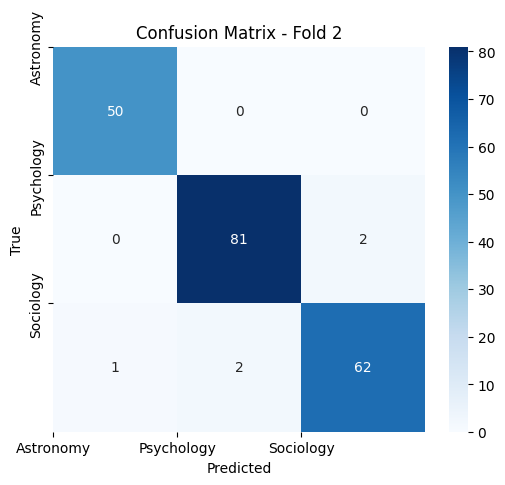

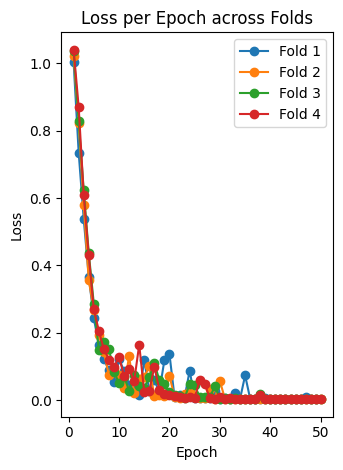

Fold 5/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_15590/3223583953.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/500 [01:14<49:21,  6.04s/it] 

{'loss': 1.0274, 'grad_norm': 4.326284408569336, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.1}


  4%|▍         | 20/500 [01:56<31:32,  3.94s/it]

{'loss': 0.8177, 'grad_norm': 3.2116129398345947, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.2}


  6%|▌         | 30/500 [02:34<29:16,  3.74s/it]

{'loss': 0.6026, 'grad_norm': 5.033091068267822, 'learning_rate': 1.88e-05, 'epoch': 0.3}


  8%|▊         | 40/500 [03:12<28:53,  3.77s/it]

{'loss': 0.3924, 'grad_norm': 2.93512225151062, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.4}


 10%|█         | 50/500 [03:49<27:13,  3.63s/it]

{'loss': 0.2962, 'grad_norm': 1.5152767896652222, 'learning_rate': 1.8e-05, 'epoch': 0.5}


 12%|█▏        | 60/500 [04:27<27:13,  3.71s/it]

{'loss': 0.2078, 'grad_norm': 2.7343249320983887, 'learning_rate': 1.76e-05, 'epoch': 0.6}


 14%|█▍        | 70/500 [05:04<26:36,  3.71s/it]

{'loss': 0.1501, 'grad_norm': 5.041490077972412, 'learning_rate': 1.72e-05, 'epoch': 0.7}


 16%|█▌        | 80/500 [05:49<27:08,  3.88s/it]

{'loss': 0.1486, 'grad_norm': 0.5161963701248169, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.8}


 18%|█▊        | 90/500 [06:28<26:33,  3.89s/it]

{'loss': 0.0871, 'grad_norm': 0.43915608525276184, 'learning_rate': 1.64e-05, 'epoch': 0.9}


 20%|██        | 100/500 [07:05<21:48,  3.27s/it]

{'loss': 0.1167, 'grad_norm': 0.5920519828796387, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                 
 20%|██        | 100/500 [07:34<21:48,  3.27s/it]

{'eval_loss': 0.09448492527008057, 'eval_runtime': 29.6233, 'eval_samples_per_second': 6.684, 'eval_steps_per_second': 0.844, 'epoch': 1.0}


 22%|██▏       | 110/500 [08:19<26:04,  4.01s/it]  

{'loss': 0.0995, 'grad_norm': 10.609663009643555, 'learning_rate': 1.5600000000000003e-05, 'epoch': 1.1}


 24%|██▍       | 120/500 [08:54<22:14,  3.51s/it]

{'loss': 0.044, 'grad_norm': 0.7437266707420349, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}


 26%|██▌       | 130/500 [09:32<24:24,  3.96s/it]

{'loss': 0.0345, 'grad_norm': 0.1936231255531311, 'learning_rate': 1.48e-05, 'epoch': 1.3}


 28%|██▊       | 140/500 [10:08<20:54,  3.49s/it]

{'loss': 0.1091, 'grad_norm': 0.2204085886478424, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.4}


 30%|███       | 150/500 [10:48<23:03,  3.95s/it]

{'loss': 0.0279, 'grad_norm': 0.3652888834476471, 'learning_rate': 1.4e-05, 'epoch': 1.5}


 32%|███▏      | 160/500 [11:28<23:08,  4.08s/it]

{'loss': 0.0993, 'grad_norm': 3.8609395027160645, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.6}


 34%|███▍      | 170/500 [12:08<20:43,  3.77s/it]

{'loss': 0.0788, 'grad_norm': 1.0777305364608765, 'learning_rate': 1.3200000000000002e-05, 'epoch': 1.7}


 36%|███▌      | 180/500 [12:45<19:55,  3.74s/it]

{'loss': 0.0988, 'grad_norm': 0.39461982250213623, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.8}


 38%|███▊      | 190/500 [13:21<18:52,  3.65s/it]

{'loss': 0.015, 'grad_norm': 0.1481216549873352, 'learning_rate': 1.2400000000000002e-05, 'epoch': 1.9}


 40%|████      | 200/500 [13:56<14:58,  2.99s/it]

{'loss': 0.0534, 'grad_norm': 0.19179877638816833, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 200/500 [14:24<14:58,  2.99s/it]

{'eval_loss': 0.06553086638450623, 'eval_runtime': 28.1309, 'eval_samples_per_second': 7.039, 'eval_steps_per_second': 0.889, 'epoch': 2.0}


 42%|████▏     | 210/500 [15:10<19:53,  4.11s/it]  

{'loss': 0.0391, 'grad_norm': 10.410924911499023, 'learning_rate': 1.16e-05, 'epoch': 2.1}


 44%|████▍     | 220/500 [15:48<17:26,  3.74s/it]

{'loss': 0.009, 'grad_norm': 0.09636493027210236, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.2}


 46%|████▌     | 230/500 [16:29<16:32,  3.68s/it]

{'loss': 0.0201, 'grad_norm': 0.23662720620632172, 'learning_rate': 1.0800000000000002e-05, 'epoch': 2.3}


 48%|████▊     | 240/500 [17:08<16:13,  3.74s/it]

{'loss': 0.0546, 'grad_norm': 2.255462408065796, 'learning_rate': 1.04e-05, 'epoch': 2.4}


 50%|█████     | 250/500 [17:52<16:26,  3.94s/it]

{'loss': 0.0087, 'grad_norm': 0.08512578159570694, 'learning_rate': 1e-05, 'epoch': 2.5}


 52%|█████▏    | 260/500 [18:29<15:25,  3.86s/it]

{'loss': 0.0408, 'grad_norm': 0.09036818891763687, 'learning_rate': 9.600000000000001e-06, 'epoch': 2.6}


 54%|█████▍    | 270/500 [19:08<15:01,  3.92s/it]

{'loss': 0.0092, 'grad_norm': 0.08588598668575287, 'learning_rate': 9.200000000000002e-06, 'epoch': 2.7}


 56%|█████▌    | 280/500 [19:46<14:12,  3.88s/it]

{'loss': 0.0059, 'grad_norm': 0.13059940934181213, 'learning_rate': 8.8e-06, 'epoch': 2.8}


 58%|█████▊    | 290/500 [20:25<13:42,  3.92s/it]

{'loss': 0.0243, 'grad_norm': 0.06019315868616104, 'learning_rate': 8.400000000000001e-06, 'epoch': 2.9}


 60%|██████    | 300/500 [21:00<09:14,  2.77s/it]

{'loss': 0.0059, 'grad_norm': 0.1651839315891266, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 300/500 [21:30<09:14,  2.77s/it]

{'eval_loss': 0.0792367085814476, 'eval_runtime': 29.5502, 'eval_samples_per_second': 6.7, 'eval_steps_per_second': 0.846, 'epoch': 3.0}


 62%|██████▏   | 310/500 [22:15<13:27,  4.25s/it]

{'loss': 0.0065, 'grad_norm': 0.0716576799750328, 'learning_rate': 7.600000000000001e-06, 'epoch': 3.1}


 64%|██████▍   | 320/500 [22:56<11:55,  3.98s/it]

{'loss': 0.0069, 'grad_norm': 0.057625751942396164, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}


 66%|██████▌   | 330/500 [24:00<16:01,  5.66s/it]

{'loss': 0.0053, 'grad_norm': 0.09305174648761749, 'learning_rate': 6.800000000000001e-06, 'epoch': 3.3}


 68%|██████▊   | 340/500 [24:37<09:26,  3.54s/it]

{'loss': 0.0052, 'grad_norm': 0.06020982190966606, 'learning_rate': 6.4000000000000006e-06, 'epoch': 3.4}


 70%|███████   | 350/500 [25:13<09:02,  3.62s/it]

{'loss': 0.0048, 'grad_norm': 0.05732271075248718, 'learning_rate': 6e-06, 'epoch': 3.5}


 72%|███████▏  | 360/500 [25:52<09:21,  4.01s/it]

{'loss': 0.0042, 'grad_norm': 0.06820740550756454, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}


 74%|███████▍  | 370/500 [26:27<07:27,  3.44s/it]

{'loss': 0.0046, 'grad_norm': 0.05765603482723236, 'learning_rate': 5.2e-06, 'epoch': 3.7}


 76%|███████▌  | 380/500 [27:29<09:35,  4.80s/it]

{'loss': 0.0042, 'grad_norm': 0.048577744513750076, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.8}


 78%|███████▊  | 390/500 [28:32<10:26,  5.70s/it]

{'loss': 0.0045, 'grad_norm': 0.19944176077842712, 'learning_rate': 4.4e-06, 'epoch': 3.9}


 80%|████████  | 400/500 [29:06<04:45,  2.86s/it]

{'loss': 0.0343, 'grad_norm': 0.08063889294862747, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 400/500 [29:33<04:45,  2.86s/it]

{'eval_loss': 0.08069784194231033, 'eval_runtime': 27.0795, 'eval_samples_per_second': 7.312, 'eval_steps_per_second': 0.923, 'epoch': 4.0}


 82%|████████▏ | 410/500 [30:36<10:29,  6.99s/it]

{'loss': 0.021, 'grad_norm': 0.04302094131708145, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.1}


 84%|████████▍ | 420/500 [31:13<04:52,  3.66s/it]

{'loss': 0.0036, 'grad_norm': 0.0546356700360775, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.2}


 86%|████████▌ | 430/500 [31:49<04:18,  3.70s/it]

{'loss': 0.0042, 'grad_norm': 0.11474603414535522, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.3}


 88%|████████▊ | 440/500 [32:25<03:35,  3.59s/it]

{'loss': 0.0042, 'grad_norm': 0.05206742137670517, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.4}


 90%|█████████ | 450/500 [33:01<02:55,  3.50s/it]

{'loss': 0.0043, 'grad_norm': 0.04993969202041626, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.5}


 92%|█████████▏| 460/500 [33:37<02:21,  3.53s/it]

{'loss': 0.004, 'grad_norm': 0.1348983347415924, 'learning_rate': 1.6000000000000001e-06, 'epoch': 4.6}


 94%|█████████▍| 470/500 [34:19<02:18,  4.63s/it]

{'loss': 0.0037, 'grad_norm': 0.048256613314151764, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.7}


 96%|█████████▌| 480/500 [35:01<01:17,  3.88s/it]

{'loss': 0.0035, 'grad_norm': 0.054724957793951035, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


 98%|█████████▊| 490/500 [35:43<00:39,  3.96s/it]

{'loss': 0.0036, 'grad_norm': 0.0421634279191494, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.9}


100%|██████████| 500/500 [36:20<00:00,  3.53s/it]

{'loss': 0.0039, 'grad_norm': 0.0702720358967781, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 500/500 [37:01<00:00,  3.53s/it]

{'eval_loss': 0.08196889609098434, 'eval_runtime': 35.5724, 'eval_samples_per_second': 5.566, 'eval_steps_per_second': 0.703, 'epoch': 5.0}


100%|██████████| 500/500 [37:06<00:00,  4.45s/it]


{'train_runtime': 2226.6167, 'train_samples_per_second': 1.781, 'train_steps_per_second': 0.225, 'train_loss': 0.09721783528476953, 'epoch': 5.0}


100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Fold 5 Evaluation Results: {'eval_loss': 0.06553086638450623, 'eval_runtime': 28.6838, 'eval_samples_per_second': 6.903, 'eval_steps_per_second': 0.872, 'epoch': 5.0}


100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


Test Accuracy: 0.9798
Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      0.98      0.99        66
  Psychology       0.97      0.98      0.98        60
   Sociology       0.97      0.97      0.97        72

    accuracy                           0.98       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.98      0.98      0.98       198

Fold 5 Confusion Matrix:
[[65  0  1]
 [ 0 59  1]
 [ 0  2 70]]
Fold 5 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      0.98      0.99        66
  Psychology       0.97      0.98      0.98        60
   Sociology       0.97      0.97      0.97        72

    accuracy                           0.98       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.98      0.98      0.98       198



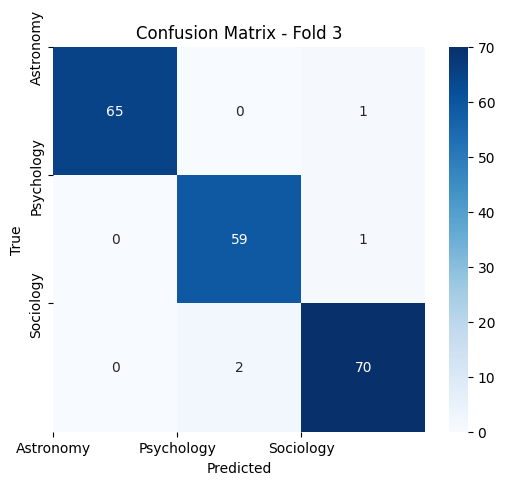

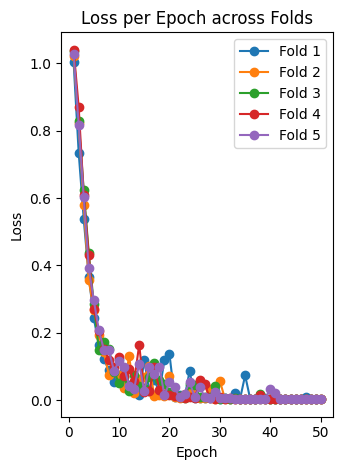

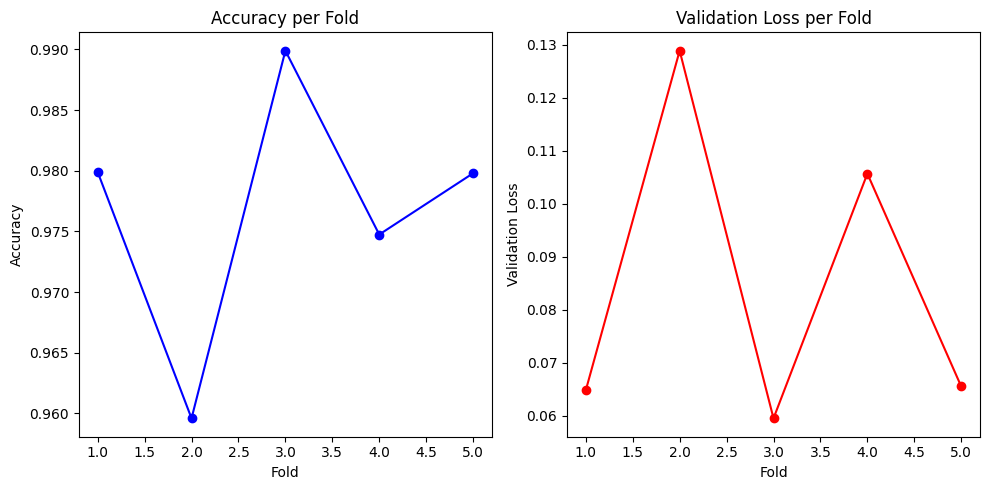

In [7]:
# Load the pre-trained DistilBERT model
num_labels = 3  # Number of categories
config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",  # Replace with your model's base name
    hidden_dropout_prob=0.3,  # Dropout rate for hidden layers
    attention_probs_dropout_prob=0.3 ,
     num_labels=3 # Dropout rate for attention probabilities
)
model_name = 'distilbert-base-uncased'
# Set base training arguments
base_training_args = {
    "evaluation_strategy": "epoch",  # Evaluate at the end of each epoch
    "save_strategy": "epoch",  # Save checkpoints at the end of each epoch
    "learning_rate": 2e-5,  # Learning rate
    "per_device_train_batch_size": 8,  # Training batch size
    "per_device_eval_batch_size": 8,  # Evaluation batch size
    "num_train_epochs": 5,  # Number of epochs
    "weight_decay": 0.01,  # Weight decay trying to avoid overfitting
    
    "logging_steps": 10,  # Log every N steps
    "save_total_limit": 2,  # Limit saved checkpoints

    "load_best_model_at_end": True,  # Load the best model at the end
}

# K-Fold Cross Validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store accuracy and loss values across folds
accuracy_per_fold = []
val_loss_per_fold = []
losses_per_fold = []  


# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Split dataset into training and validation sets
    train_fold = train_dataset.select(train_idx)
    val_fold = train_dataset.select(val_idx)
    
    # Initialize the model for this fold
    model = DistilBertForSequenceClassification.from_pretrained(model_name,config=config)
    
    # Create training arguments specific to the fold
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",  # Unique output dir for each fold
        logging_dir=f"./logs_fold_{fold + 1}",  # Unique log dir for each fold
        **base_training_args,
    )
    loss_logger_callback = LossLoggerCallback()
    
    # Instantiate Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_fold,
        eval_dataset=val_fold,
        tokenizer=tokenizer,
        callbacks=[loss_logger_callback],
    )
    
    # Train the model
    #Defined the epoch in the 
    trainer.train()

    losses_per_fold.append(loss_logger_callback.get_losses())
    
    # Optionally evaluate and log metrics
    eval_results = trainer.evaluate()
    print(f"Fold {fold + 1} Evaluation Results: {eval_results}")
    # Save the model for the current fold
    #trainer.save_model(f"./best_model_fold_{fold + 1}")
    #don't need
    
    # Compute predictions and true labels for confusion matrix
    predictions, true_labels, _ = trainer.predict(val_fold)
    pred_labels = np.argmax(predictions, axis=1)
    
    # Compute confusion matrix and classification report
    cm = confusion_matrix(true_labels, pred_labels)
    report = classification_report(true_labels,pred_labels, target_names=['Astronomy', 'Psychology', 'Sociology'])
    accuracy=accuracy_score(true_labels,pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels,pred_labels, average=None)  # Per-class metrics
    f1_macro = precision_recall_fscore_support(true_labels,pred_labels, average='macro')[2]
    f1_weighted = precision_recall_fscore_support(true_labels,pred_labels, average='weighted')[2]
    f1_micro = precision_recall_fscore_support(true_labels,pred_labels, average='micro')[2]
    #Print report 
    print("Test Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:")
    print(report)
  
    # Print confusion matrix
    print(f"Fold {fold + 1} Confusion Matrix:")
    print(cm)
    # Print classification report
    print(f"Fold {fold + 1} Classification Report:")
    print(report)
    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_labels), yticklabels=np.arange(num_labels))
    plt.title(f"Confusion Matrix - Fold {fold - 1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(3), ['Astronomy', 'Psychology', 'Sociology'])
    plt.yticks(range(3), ['Astronomy', 'Psychology', 'Sociology'])
    plt.show()

    

    
    # Store accuracy and validation loss for plotting
    accuracy_per_fold.append(accuracy)
    val_loss_per_fold.append(eval_results['eval_loss'])

 

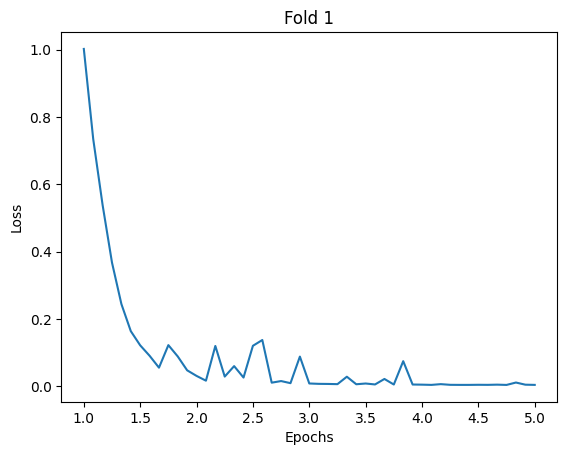

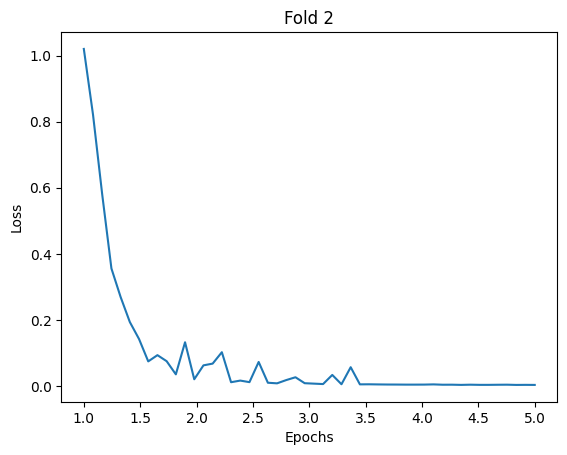

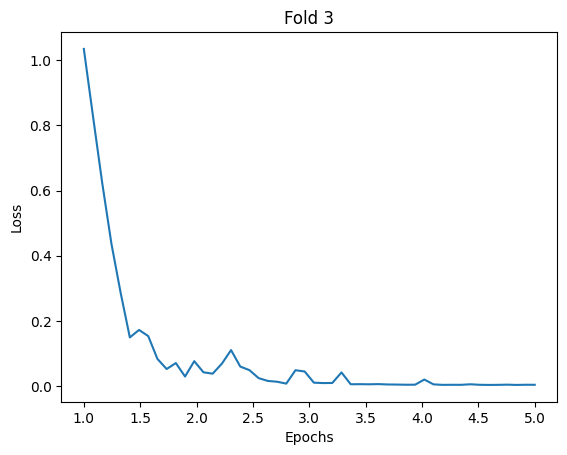

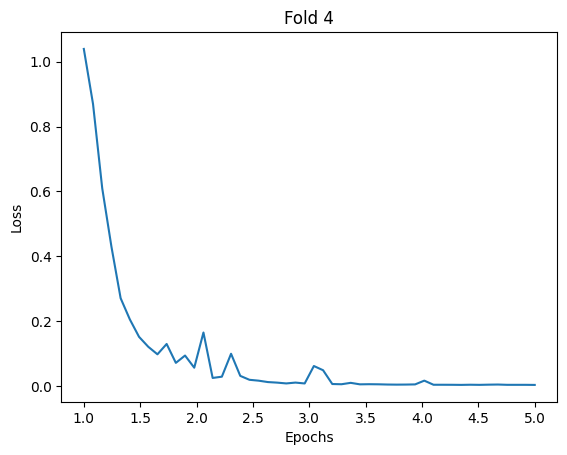

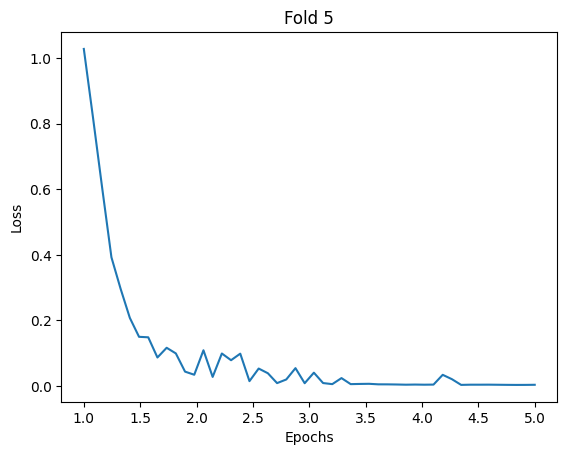

In [46]:



folds = [np.array(fold) for fold in losses_per_fold]  # Convert to a list of arrays

# Create a separate plot for each fold
for i in range(len(folds)):
    plt.figure()  # Start a new figure for each fold
    
    # Spread 50 data points evenly across 5 epochs (create custom x-axis)
    epochs = np.linspace(1, 5, len(folds[i]))  # Mapping 50 data points to range 1 to 5
    
    plt.plot(epochs, folds[i])  # Plot using custom x-axis (epochs)
    plt.title(f"Fold {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Display the plot
    plt.show()

In [62]:
average_loss=[]
for i in range(5):
    average_loss.append(np.mean(folds[i]))
print(average_loss)


[0.09113061224489795, 0.08837, 0.093856, 0.09621400000000001, 0.09721999999999997]


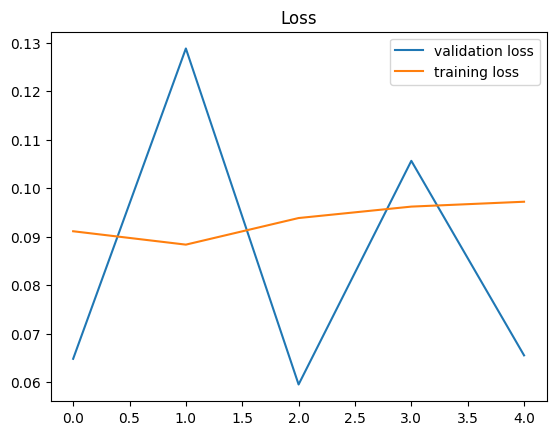

Text(0.5, 1.0, 'Accuracy')

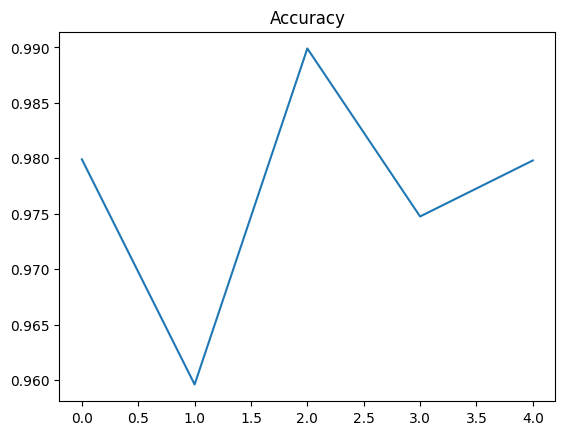

In [68]:

plt.plot(val_loss_per_fold,label="validation loss")
plt.plot(average_loss,label="training loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.plot(accuracy_per_fold)
plt.title("Accuracy")

In [8]:
# Save model and tokenizer
model.save_pretrained('./bert_Abstract_classifier_model_with_KFOLD_trainer_api')
tokenizer.save_pretrained('./bert_Abstract_classifier_model_with_KFOLD_trainer_api')

('./bert_Abstract_classifier_model_with_KFOLD_trainer_api/tokenizer_config.json',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/special_tokens_map.json',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/vocab.txt',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/added_tokens.json')